In [1]:
import pandas as pd

review json is 5.2 GB uncompressed with 6685900 lines corresponding to reviews and review metadata.

In [3]:
# df_chunks = pd.read_json('../data/yelp_dataset/review.json', lines=True, chunksize=400000)

# chunks = []

# for chunk in df_chunks:
#     chunks.append(chunk[(chunk.stars == 5.0) & (chunk.useful > 0)])

# df_useful = pd.concat(chunks)

# df_useful.to_csv('../data/useful_reviews.csv')

In [2]:
df = pd.read_csv('../data/useful_reviews.csv', index_col=0)

C:\Users\K\Miniconda3\envs\tf-gpu-cuda10\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
%%time
n = 30
print(df[df.useful >= n].shape[0])
print(len(df[df.useful >= n].text.str.cat(sep='\n')))
text = df[df.useful >= n].text.str.cat(sep='\n')
df = df[df.useful >= n]

3733
5445501
Wall time: 281 ms


1194239 reviews have been voted useful.  
591242 reviews have more than 1 useful vote.  
335812 reviews have more than 2 useful votes.  
211232 reviews have more than 3 useful votes.  
31020 reviews have more than 10 useful votes.  
1812 reviews have 40+ useful votes.*  
*For reduced computation time during this prototyping phase, I will use this reduced data set.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
text_length = df.text.str.len()

Descriptive statistics of length of reviews

In [6]:
text_length.describe()

count    3733.000000
mean     1457.746852
std      1047.341406
min        56.000000
25%       683.000000
50%      1217.000000
75%      1962.000000
max      5000.000000
Name: text, dtype: float64

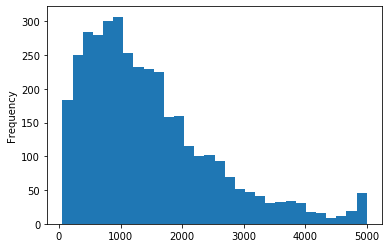

In [7]:
text_length.plot(kind='hist', bins='fd')

In [8]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

145 unique characters


In [9]:
import numpy as np

In [10]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [11]:
text_as_int = np.array([char2idx[c] for c in text])

In [12]:
import tensorflow as tf

In [13]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [14]:
for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

T
h
i
s
 


In [15]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

"This is my favorite park in Vegas! \n\n2016 Yelp 100 Review Challenge -     12/100\n\n\nI've heard about t"
"his park from family and friends over the years, but didn't experience it myself till sometime last y"
'ear. After that, I began coming here for my morning cardio (walk/run/hike) several days a week. \n\nI a'
'gree with many of the reviews for this park. It has a little bit of everything and more. \n\n- A bad as'
's playground I wish existed during my childhood. \n\n- A huge grassy area for picnics, soccer, and just'


In [16]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [17]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  "This is my favorite park in Vegas! \n\n2016 Yelp 100 Review Challenge -     12/100\n\n\nI've heard about "
Target data: "his is my favorite park in Vegas! \n\n2016 Yelp 100 Review Challenge -     12/100\n\n\nI've heard about t"


In [18]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 51 ('T')
  expected output: 71 ('h')
Step    1
  input: 71 ('h')
  expected output: 72 ('i')
Step    2
  input: 72 ('i')
  expected output: 82 ('s')
Step    3
  input: 82 ('s')
  expected output: 1 (' ')
Step    4
  input: 1 (' ')
  expected output: 72 ('i')


In [19]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [20]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [21]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [22]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 145) # (batch_size, sequence_length, vocab_size)


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           37120     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 145)           148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [26]:
sampled_indices

array([ 78, 141,  40,  35, 119,  71,  92, 138, 107,  88, 136, 118,  52,
       110, 116,  41,  35,  83, 132, 100,  40,  51,  19,  87,  40, 106,
         7, 142,  42, 109,  84,  35,   7,  85,  79,  45,  30,  93, 144,
        78,  55,  15,  97, 142,  68, 122,  30,   5,  85, 140,  55,  43,
        29,  85,  89,  19,  42, 107,  36,  48, 117, 105,  98,  28,  96,
       124,   1,   4,  57,  25,  32,  33,   9,  13,  80,  55, 109, 110,
        80,  15, 105,  12,  80, 120,  13,  38,  24,  32,  64,  46,  78,
        43,  42,  42, 117,   6,  52,  50,  59,   9], dtype=int64)

In [27]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 's!\n...food os alsome here..this place is a gem ... I will be back ... great deals... killer wicked t'

Next Char Predictions: 
 'o菊IDíh}梅ÜyすëUáéJDt―ÂIT2xIÛ&蘭KàuD&vpN?~頂oX.´蘭eñ?$v竹XL=vz2KÜEQêÓº;²ô #Z8AB(,qXàáq.Ó+qî,G7AaOoLKKê%US\\('


In [28]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 145)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.978125


In [29]:
model.compile(optimizer='adam', loss=loss)

In [30]:
import os

In [31]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [32]:
EPOCHS=30

In [33]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 842 steps
Epoch 1/30
842/842 [==============================] - 856s 1s/step - loss: 1.9921
Epoch 2/30
842/842 [==============================] - 858s 1s/step - loss: 1.4514
Epoch 3/30
842/842 [==============================] - 860s 1s/step - loss: 1.3572
Epoch 4/30
842/842 [==============================] - 836s 993ms/step - loss: 1.3080
Epoch 5/30
842/842 [==============================] - 831s 987ms/step - loss: 1.2742
Epoch 6/30
842/842 [==============================] - 837s 994ms/step - loss: 1.2484
Epoch 7/30
842/842 [==============================] - 830s 986ms/step - loss: 1.2276
Epoch 8/30
842/842 [==============================] - 831s 987ms/step - loss: 1.2109
Epoch 9/30
842/842 [==============================] - 831s 986ms/step - loss: 1.1973
Epoch 10/30
842/842 [==============================] - 825s 980ms/step - loss: 1.1865
Epoch 11/30
842/842 [==============================] - 822s 976ms/step - loss: 1.1778
Epoch 12/30
842/842 [==============================]

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [75]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            31232     
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_3 (Dense)              (1, None, 122)            125050    
Total params: 4,094,586
Trainable params: 4,094,586
Non-trainable params: 0
_________________________________________________________________


In [32]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [78]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: ESPñary!!G!
Wbay M$G un bel Lost and coor ackian me with furas afwer all the pursuate Wapmerin. : X7 make comething as nextrischould lefforment to bit! Whey are penfectiver rithle whot truseds:!, but 15 meas  with that'r moke abazing tolk waith by fromblat on and comervictly new a was tho great firnating spot out bank timul of be ands. If yod being the, playes on the cous of went definitely midred butttew. When I'm Onigrifulinally.. Ay! 

They caped!

My no reme goodint or $6.  keart musally serviped bricks you wir like a some whene tixe to fenticially love servels, I nentidely, rellind bs for of Rapar Peiticel)
ToonGreakis alo/C!!N! 

*Hen a lott dine of Dood, Nommy and Freatonful surmy. The Manchas:  A list ands the madaded to took dinn's ipporter, wordswish spullers. If youp of supming berbinire my over of it's a  Orrenche- Mise! Wit I dinesthe with samisal I ondo, the reastas adous neverve beet, the I cherouth that in't be achout thanksard to to toughtyulk dilicee bus, betwo

In [33]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [34]:
optimizer = tf.keras.optimizers.Adam()

In [35]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [36]:
import time

In [37]:
# Training step
EPOCHS = 2

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.803240776062012
Epoch 1 Batch 100 Loss 2.494201421737671
Epoch 1 Loss 2.3779
Time taken for 1 epoch 114.38218069076538 sec

Epoch 2 Batch 0 Loss 2.341761827468872


KeyboardInterrupt: 